# Librerias

In [1]:
import torch, random, math
import numpy as np
import torch.nn.functional as F
from tqdm import tnrange
from time import time
from torch import nn
from torchtext import data
from torch.autograd import Variable
from iseq2seq.utils import load_anki_dataset, write_training_log

import matplotlib.pyplot as plt
%matplotlib inline

# Cargar data

In [2]:
batch_size = 128
data_path = 'data/dataset.pkl'

ds_train, ds_test, ds_val, ES, EN = load_anki_dataset(data_path)
es_dict = {v:k for k,v in ES.vocab.stoi.items()}
en_dict = {v:k for k,v in EN.vocab.stoi.items()}

train_buckets = data.BucketIterator(ds_train, batch_size,
    sort_key=lambda x: data.interleave_keys(len(x.es), len(x.en)))
test_buckets = data.BucketIterator(ds_test, batch_size,
    sort_key=lambda x: data.interleave_keys(len(x.es), len(x.en)))
val_buckets = data.BucketIterator(ds_val, batch_size,
    sort_key=lambda x: data.interleave_keys(len(x.es), len(x.en)))
train_iter = iter(train_buckets)
test_iter = iter(test_buckets)
val_iter = iter(val_buckets)
epoch_batchs_train = math.ceil(len(train_buckets.dataset.examples) / train_buckets.batch_size)
epoch_batchs_train



    Only loading the 'es' tokenizer.



    Only loading the 'en' tokenizer.



801

In [3]:
train_max_length = 0

for ex in train_buckets.dataset.examples:
    train_max_length = max(train_max_length, len(ex.en))
    
train_max_length

25

In [4]:
SOS_token = EN.vocab.stoi['<sos>']
EOS_token = EN.vocab.stoi['<eos>']
SOS_token, EOS_token

(2, 3)

# Encoder

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, bidirectional=False,
                 embedding_dropout=0, rnn_dropout=0):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.embedding_dropout = embedding_dropout
        self.rnn_dropout = rnn_dropout
        
        # Layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.embedding_dropout = nn.Dropout(embedding_dropout)
        self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=n_layers,
                          bidirectional=bidirectional, dropout=rnn_dropout)
        
    def forward(self, input, hidden):
        embs = self.embedding(input)
        embs = self.embedding_dropout(embs)
        output, hidden = self.rnn(embs, hidden)
        if self.bidirectional:
            # En caso el encoder sea bidireccional, se suman los outputs
            # en vez de concatenarlos.
            output = output[:, :, :self.hidden_size] + output[:, : ,self.hidden_size:]
        
        return output, hidden

# Attention Decoder

In [6]:
class Attention(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        
        # metodos definidos en https://arxiv.org/pdf/1508.04025.pdf
        assert method in ('dot', 'general', 'concat'), 'invalid attention method'
        
        # Layers
        if self.method == 'general':
            self.att = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.att = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Se inicializa las energias de atencion y se calculan en cada elemento del batch
        att_energies = Variable(torch.zeros(this_batch_size, max_len)).cuda()

        for b in range(this_batch_size): # por cada elemento b del batch
            for i in range(max_len): # por cada paso i de la secuencia
                att_energies[b, i] = self.score(hidden[:, b].squeeze(0),
                                                encoder_outputs[i, b])

        # Se normalizan los pesos entre 0 y 1
        return F.softmax(att_energies).unsqueeze(1)
    
    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.att(encoder_output)
            energy = hidden.dot(energy)
            return energy
        
        elif self.method == 'concat':
            energy = self.att(torch.cat((hidden, encoder_output), 1))
            energy = self.v.dot(energy)
            return energy

class AttnDecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, n_layers=1,
                 att_method='general', embedding_dropout=0, rnn_dropout=0):
        super(AttnDecoderRNN, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.att_method = att_method
        self.embedding_dropout = embedding_dropout
        self.rnn_dropout = rnn_dropout

        # Layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(embedding_dropout)
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, dropout=rnn_dropout)
        self.attention = Attention(att_method, hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, last_hidden, encoder_outputs):
        # ojo: input es el batch de los ultimos outputs, no es una secuencia
        batch_size = input.size(0)
        embs = self.embedding(input)
        embs = self.embedding_dropout(embs)
        embs = embs.view(1, batch_size, self.hidden_size)

        # Se corre la RNN en el input con el ultimo hidden state
        rnn_output, hidden = self.rnn(embs, last_hidden)
        
        # Se calcula la atencion y se aplica a las salidas del encoder
        att_weights = self.attention(rnn_output, encoder_outputs)
        context = att_weights.bmm(encoder_outputs.transpose(0, 1))
        
        # Se concatenan los valores de salida de la rnn y el contexto
        concat_input = torch.cat((rnn_output.squeeze(0), context.squeeze(1)), 1)
        concat_output = F.tanh(self.concat(concat_input))
        output = self.out(concat_output)

        return output, hidden, att_weights
    

# Cargar Embeddings (Glove)

In [7]:
# TODO

# Training

In [81]:
def train_epoch(epoch_desc, epoch_batchs, tf_ratio, gradient_clip=5.0, data_set='train'):
    avg_mom = 0.9
    avg_loss = 0.0
    debias_loss = 0.0
    
    if data_set == 'train':
        encoder.train(True)
        decoder.train(True)
    else:
        encoder.train(False)
        decoder.train(False)
    
    if data_set == 'train':
        range_fun = tnrange(epoch_batchs, desc=epoch_desc)
    else:
        range_fun = tnrange(epoch_batchs, desc=epoch_desc, leave=False)
    
    for it in range_fun:
        range_fun.set_postfix(loss=debias_loss, teacher_forcing=tf_ratio)
        
        # Inicializar gradientes y perdida
        if data_set == 'train':
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            
        # Obtener batch de entrenamiento
#         ### debug gpu memory
#         for _ in range(5000):
#             training_batch = next(train_iter)
#             if training_batch.en.size(0) > 22:
#                 break
#         ### debug gpu memory
        if data_set == 'train':
            training_batch = next(train_iter)
        elif data_set == 'test':
            training_batch = next(test_iter)
        elif data_set == 'validation':
            training_batch = next(val_iter)
            
        input_variable = training_batch.es
        target_variable = training_batch.en
        input_length, batch_size  = input_variable.size()
        target_length = target_variable.size()[0]

        # Encodear el input
        encoder_outputs, encoder_hidden = encoder(input_variable, None)

        # Crear variables para el input y output del decoder
        decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size)).cuda()
        # Fix, las ultimas capas en caso de bidireccional
        decoder_hidden = encoder_hidden[-decoder.n_layers:]
        all_decoder_outputs = Variable(torch.zeros(
            target_length, batch_size, decoder.output_size)).cuda()

        # Se ejecuta el decoder en cada paso de la secuencia
        for t in range(target_length):
            decoder_output, decoder_hidden, decoder_att = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            all_decoder_outputs[t] = decoder_output

            if t < target_length-1:
                # Usar teacher_forcing
                use_tf = random.random() < tf_ratio
                if use_tf:
                    # De la data
                    decoder_input = target_variable[t+1]
                else:
                    # Del modelo
                    decoder_input = decoder_output.topk(1, 1)[1]

        # Funcion de perdida
        log_probs = F.log_softmax(all_decoder_outputs.view(-1, decoder.output_size))
        loss = nn.NLLLoss()(log_probs, target_variable.view(-1))
        avg_loss = avg_loss * avg_mom + loss.data[0] * (1-avg_mom)
        debias_loss = avg_loss / (1 - avg_mom**(it+1))
        
        # Optimizar parametros
        if data_set == 'train':
#             ### debug gpu memory
#             print(input_length, target_length, avg_loss, loss.data[0], debias_loss)
#             try:
#                 loss.backward()
#             except RuntimeError:
#                 import pdb; pdb.set_trace()
#             ### debug gpu memory
                
            loss.backward()
            nn.utils.clip_grad_norm(encoder.parameters(), gradient_clip)
            nn.utils.clip_grad_norm(decoder.parameters(), gradient_clip)
            encoder_optimizer.step()
            decoder_optimizer.step()
    
    return avg_loss if it > 100 else debias_loss


In [9]:
def predict(batch, max_target_length=train_max_length):
    input_length, batch_size  = batch.size()
    target_length = min(train_max_length, input_length*2)
    eos_check = torch.LongTensor([EOS_token] * batch_size).cuda()
    out = []
    
    # Encodear el input
    encoder_outputs, encoder_hidden = encoder(batch, None)

    # Crear variables para el input y output del decoder
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size)).cuda()
    # Fix, las ultimas capas en caso de bidireccional
    decoder_hidden = encoder_hidden[-decoder.n_layers:]

    # Se ejecuta el decoder en cada paso de la secuencia
    for t in range(target_length):
        decoder_output, decoder_hidden, decoder_att = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        if t < target_length-1:
            decoder_input = decoder_output.topk(1, 1)[1]
            out.append(decoder_input)

        if torch.sum(decoder_input.data.squeeze() == eos_check) == batch_size:
            break
                
    return torch.cat(out, 1).transpose(0, 1).data.cpu().numpy()

In [10]:
perplexity = lambda x: math.exp(float(x)) if x < 300 else float("inf")

def train(epochs, model_name, tf_ratio=1.0, tf_epoch_end=0, results_each=5,
          n_examples=3, save_each=5, epoch_batchs_test=10, gradient_clip=5.0):
    t0 = time()
    results = {}
    train_loss = []
    test_loss = []
    zeros = int(math.log10(epochs)) + 1
    
    # teacher forcing interpolation
    tf = np.zeros(epochs)
    tf[:tf_epoch_end] = np.linspace(tf_ratio, 0, tf_epoch_end)
    
    try:
        for i in tnrange(epochs, desc='Training'):
            # Entrenar una epoca
            l = train_epoch(f'Epoch {i+1:0{zeros}}', epoch_batchs_train,
                            tf[i], gradient_clip)
            train_loss.append(l)

            # Evaluar perdida en el test set (sin teacher forcing)
            l = train_epoch(f'Test Loss', epoch_batchs_test,
                            0, gradient_clip, data_set='test')
            test_loss.append(l)

            # Guardar modelo
            if (i+1) % save_each == 0:
                torch.save(encoder.state_dict(), f'data/{model_name}_encoder.pkl')
                torch.save(decoder.state_dict(), f'data/{model_name}_decoder.pkl')

            # Mostrar resultados
            if (i+1) % results_each == 0:
                print('Teacher forcing ratio=%.2f' % tf[i])
                print('Train loss=%.5f, perplexity=%.5f' %
                      (train_loss[-1], perplexity(train_loss[-1])))
                print('Test  loss=%.5f, perplexity=%.5f\n' %
                      (test_loss[-1], perplexity(test_loss[-1])))

                # Ejemplos de traduccion
                examples = next(train_iter)
                examples_es = examples.es[:,:n_examples]
                examples_en = examples.en[:,:n_examples].data.cpu().numpy()
                predicted = predict(examples_es)
                examples_es = examples_es.data.cpu().numpy()
                for j in range(n_examples):
                    print(' '.join([es_dict[w] for w in examples_es[:, j]]))
                    print('Result -> ', ' '.join([en_dict[w] for w in predicted[:, j]]))
                    print('Target -> ', ' '.join([en_dict[w] for w in examples_en[:, j]]), '\n')
        
            write_training_log(f'data/{model_name}_log.txt', i,
                               tf[i], train_loss[-1], test_loss[-1])
            
    except KeyboardInterrupt:
        print('Interrupted at epoch: %d' % (i+1))
        
    results['train_loss'] = train_loss
    results['test_loss'] = test_loss
        
    torch.save(encoder.state_dict(), f'data/{model_name}_encoder.pkl')
    torch.save(decoder.state_dict(), f'data/{model_name}_decoder.pkl')
    
    return results

# Definir el modelo

In [11]:
model_name = 'seq2seq'
encoder_hidden = 256
encoder_bi = True
n_layers = 2
lr = 0.0001
teacher_forcing_epoch_end = 5
epochs = 10

encoder = EncoderRNN(len(ES.vocab.itos), encoder_hidden, n_layers, bidirectional=encoder_bi).cuda()
decoder = AttnDecoderRNN(len(EN.vocab.itos), encoder_hidden, n_layers).cuda()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

In [12]:
# # Cargar pesos
# encoder.load_state_dict(torch.load(f'data/{model_name}_encoder.pkl'))
# decoder.load_state_dict(torch.load(f'data/{model_name}_decoder.pkl'))

# Pruebas

In [83]:
%pdb

Automatic pdb calling has been turned OFF


In [85]:
# l = train_epoch('asd', 500, 0.5, data_set='train')
# l

In [86]:
# Test
epoch_batchs_train = 10
results = train(10, model_name, tf_epoch_end=5, results_each=5, epoch_batchs_test=3)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Teacher forcing ratio=0.00
Train loss=4.26967, perplexity=71.49800
Test  loss=4.14068, perplexity=62.84562

¿ sabes dónde está ?
Result ->  <sos> i you you ? ? <eos> <eos>
Target ->  <sos> do you know where it is ? <eos> 

debes ir al médico .
Result ->  <sos> i i . . . . <eos>
Target ->  <sos> you must go to the doctor . <eos> 

sigo buscando a tom .
Result ->  <sos> i i . . . . <eos>
Target ->  <sos> i 'm still looking for tom . <eos> 



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Teacher forcing ratio=0.00
Train loss=4.27118, perplexity=71.60582
Test  loss=4.60387, perplexity=99.87044

parece que tom estuvo aquí .
Result ->  <sos> i i the . . . <eos>
Target ->  <sos> it seems that tom has been here . <eos> <pad> 

gracias por comprarme esta revista .
Result ->  <sos> i i . . . <eos> <eos>
Target ->  <sos> thank you for buying me this magazine . <eos> <pad> 

estoy feliz porque estás acá .
Result ->  <sos> i i . . . <eos> <eos>
Target ->  <sos> i 'm happy because you 're here . <eos> <pad> 



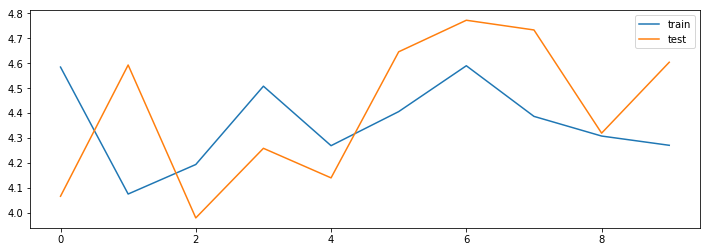

In [87]:
# Test
plt.figure(figsize=(12,4))
plt.plot(results['train_loss'], label='train')
plt.plot(results['test_loss'], label='test')
plt.legend();

# Entrenamiento

In [ ]:
# results = train(epochs, teacher_forcing_epoch_end, model_name)

In [ ]:
# plt.figure(figsize=(12,4))
# plt.plot(results['train_loss'], label='train')
# plt.plot(results['test_loss'], label='test')
# plt.legend();

# Ver resultados

In [89]:
n_examples = 5
examples = next(train_iter)
examples_es = examples.es[:,:n_examples]
examples_en = examples.en[:,:n_examples].data.cpu().numpy()
predicted = predict(examples_es)
examples_es = examples_es.data.cpu().numpy()
for i in range(n_examples):
    print(' '.join([es_dict[w] for w in examples_es[:, i]]))
    print('Result -> ', ' '.join([en_dict[w] for w in predicted[:, i]]))
    print('Target -> ', ' '.join([en_dict[w] for w in examples_en[:, i]]), '\n')
    # TODO: plot attention

nadie lo sabía . <pad> <pad>
Result ->  <sos> i i . . . . <eos>
Target ->  <sos> nobody knew . <eos> <pad> 

me quedé dormido . <pad> <pad>
Result ->  <sos> i is . . . . <eos>
Target ->  <sos> i overslept . <eos> <pad> 

<unk> a tomás . <pad> <pad>
Result ->  <sos> i is . . . . <eos>
Target ->  <sos> follow tom . <eos> <pad> 

no te muevas . <pad> <pad>
Result ->  <sos> i i the . . . <eos>
Target ->  <sos> be still . <eos> <pad> 

¿ quién escuchó ? <pad> <pad>
Result ->  <sos> i you you ? ? <eos> <eos>
Target ->  <sos> who listened ? <eos> <pad> 

